In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [11]:
train_data = pd.read_csv('loan_train.csv')
test_data = pd.read_csv('loan_test.csv')

In [4]:
train_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,42788,21,102000,MORTGAGE,5.0,EDUCATION,A,10000,7.51,0.10,N,4,0
1,11553,23,49000,RENT,1.0,HOMEIMPROVEMENT,D,5000,13.17,0.10,Y,4,1
2,27481,23,30000,RENT,1.0,MEDICAL,B,10000,11.99,0.33,N,4,1
3,39841,32,95000,MORTGAGE,9.0,HOMEIMPROVEMENT,C,15000,12.84,0.16,Y,5,0
4,55662,31,32000,MORTGAGE,3.0,HOMEIMPROVEMENT,A,1200,7.68,0.04,N,10,0


In [5]:
X_train = train_data.drop('loan_status', axis=1)  # loan_status - целевая переменная
y_train = train_data['loan_status']
X_test = test_data.drop('loan_status', axis=1)
y_test = test_data['loan_status']

In [7]:
print(train_data.dtypes)

id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object


In [14]:
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols),  # Применяем OneHotEncoder к категориальным столбцам
        ('num', StandardScaler(), X_train.select_dtypes(include=['int64', 'float64']).columns)  # Масштабируем числовые признаки
    ])

In [20]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [21]:
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [24]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

Эксперимент 1. Простая модель

In [26]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Первый линейный слой
        self.fc2 = nn.Linear(hidden_size, hidden_size*4)  # Второй линейный слой
        self.fc3 = nn.Linear(hidden_size*4, 1)  # Выходной слой
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Применяем ReLU после первого слоя
        x = self.relu(self.fc2(x))  # Применяем ReLU после второго слоя
        x = torch.sigmoid(self.fc3(x))  # Применяем Sigmoid для выхода в диапазоне [0, 1]
        return x.squeeze()

In [27]:
model = SimpleModel(input_size=X_train_processed.shape[1], hidden_size=32)

In [28]:
criterion = nn.BCELoss()  # Бинарная кросс-энтропия для бинарной классификации
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [30]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_losses = []
    test_losses = []
    train_roc_auc = []
    test_roc_auc = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            all_preds.append(outputs.detach().numpy())
            all_labels.append(labels.numpy())

        # Средний loss для train
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Вычисление ROC-AUC для train
        train_preds = np.concatenate(all_preds)
        train_labels = np.concatenate(all_labels)
        train_roc_auc_score = roc_auc_score(train_labels, train_preds)
        train_roc_auc.append(train_roc_auc_score)

        # Тестирование модели
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                all_preds.append(outputs.numpy())
                all_labels.append(labels.numpy())

        # Средний loss для test
        test_loss = test_loss / len(test_loader)
        test_losses.append(test_loss)

        # Вычисление ROC-AUC для test
        test_preds = np.concatenate(all_preds)
        test_labels = np.concatenate(all_labels)
        test_roc_auc_score = roc_auc_score(test_labels, test_preds)
        test_roc_auc.append(test_roc_auc_score)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, '
              f'Train ROC-AUC: {train_roc_auc_score:.4f}, Test ROC-AUC: {test_roc_auc_score:.4f}')

    # Построение графиков
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_roc_auc, label='Train ROC-AUC')
    plt.plot(test_roc_auc, label='Test ROC-AUC')
    plt.xlabel('Epoch')
    plt.ylabel('ROC-AUC')
    plt.legend()

    plt.show()


Epoch 1/10, Train Loss: 0.2686, Test Loss: 0.2435, Train ROC-AUC: 0.8871, Test ROC-AUC: 0.9063
Epoch 2/10, Train Loss: 0.2429, Test Loss: 0.2281, Train ROC-AUC: 0.9010, Test ROC-AUC: 0.9132
Epoch 3/10, Train Loss: 0.2313, Test Loss: 0.2197, Train ROC-AUC: 0.9071, Test ROC-AUC: 0.9174
Epoch 4/10, Train Loss: 0.2227, Test Loss: 0.2127, Train ROC-AUC: 0.9119, Test ROC-AUC: 0.9209
Epoch 5/10, Train Loss: 0.2159, Test Loss: 0.2072, Train ROC-AUC: 0.9159, Test ROC-AUC: 0.9237
Epoch 6/10, Train Loss: 0.2105, Test Loss: 0.2042, Train ROC-AUC: 0.9188, Test ROC-AUC: 0.9254
Epoch 7/10, Train Loss: 0.2062, Test Loss: 0.2003, Train ROC-AUC: 0.9210, Test ROC-AUC: 0.9264
Epoch 8/10, Train Loss: 0.2024, Test Loss: 0.1971, Train ROC-AUC: 0.9229, Test ROC-AUC: 0.9277
Epoch 9/10, Train Loss: 0.1995, Test Loss: 0.1943, Train ROC-AUC: 0.9238, Test ROC-AUC: 0.9285
Epoch 10/10, Train Loss: 0.1971, Test Loss: 0.1929, Train ROC-AUC: 0.9252, Test ROC-AUC: 0.9289


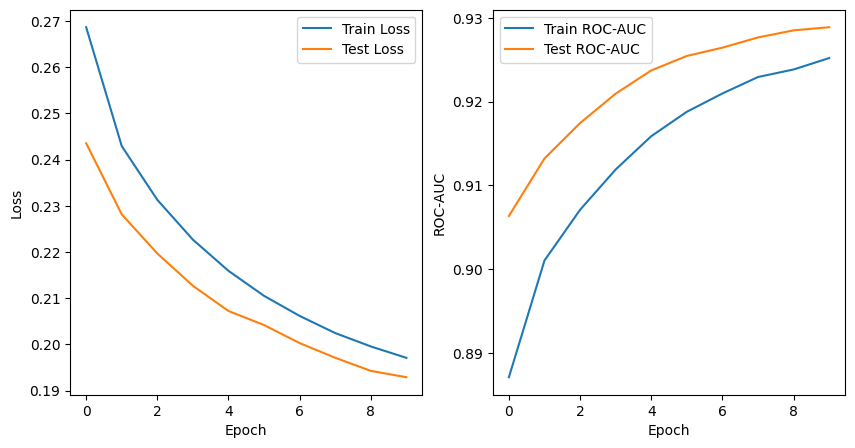

In [33]:
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

Вывод: Модель улучшает свои результаты по мере обучения. Потери (Train и Test Loss) и ROC-AUC увеличиваются с каждой эпохой, точность улучшается. Улучшения становятся менее заметными после 9-й эпохи, что говорит о стабилизации. Оптимальное количество эпох — 10 или немного меньше, чтобы избежать переобучения.

Эксперимент 2. Модель побольше

In [34]:
class BiggerModel(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(BiggerModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size*4)
        self.fc3 = nn.Linear(hidden_size*4, hidden_size*2)
        self.fc4 = nn.Linear(hidden_size*2, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x.squeeze()

In [35]:
model = BiggerModel(input_size=X_train_processed.shape[1], hidden_size=128)
optimizer = optim.SGD(model.parameters(), lr=0.01)

Epoch 1/10, Train Loss: 0.3505, Test Loss: 0.2620, Train ROC-AUC: 0.7809, Test ROC-AUC: 0.8950
Epoch 2/10, Train Loss: 0.2491, Test Loss: 0.2266, Train ROC-AUC: 0.8965, Test ROC-AUC: 0.9145
Epoch 3/10, Train Loss: 0.2279, Test Loss: 0.2150, Train ROC-AUC: 0.9090, Test ROC-AUC: 0.9216
Epoch 4/10, Train Loss: 0.2173, Test Loss: 0.2072, Train ROC-AUC: 0.9156, Test ROC-AUC: 0.9259
Epoch 5/10, Train Loss: 0.2096, Test Loss: 0.1999, Train ROC-AUC: 0.9200, Test ROC-AUC: 0.9283
Epoch 6/10, Train Loss: 0.2031, Test Loss: 0.1961, Train ROC-AUC: 0.9230, Test ROC-AUC: 0.9297
Epoch 7/10, Train Loss: 0.1980, Test Loss: 0.1915, Train ROC-AUC: 0.9256, Test ROC-AUC: 0.9306
Epoch 8/10, Train Loss: 0.1938, Test Loss: 0.1890, Train ROC-AUC: 0.9270, Test ROC-AUC: 0.9313
Epoch 9/10, Train Loss: 0.1907, Test Loss: 0.1863, Train ROC-AUC: 0.9281, Test ROC-AUC: 0.9315
Epoch 10/10, Train Loss: 0.1880, Test Loss: 0.1866, Train ROC-AUC: 0.9294, Test ROC-AUC: 0.9311


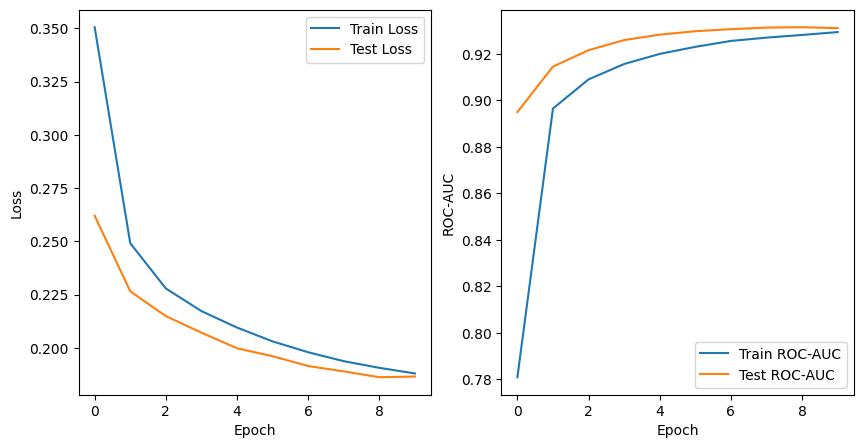

In [36]:
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

Вывод: Модель стала лучше: вторая модель имеет более низкие значения потерь и более высокие значения ROC-AUC на обоих наборах данных, особенно в отношении ROC-AUC. Улучшения в обеих сериях заметны, но вторая модель демонстрирует более сильное улучшение, особенно по сравнению с начальными значениями.

Поведение модели: Модель продолжает улучшать свои показатели с каждой эпохой, но на последних эпохах прирост становится менее заметным, что указывает на стабилизацию

Эксперимент 3. Skip Connections, Batch Norms

In [39]:
class ModelWithBatchNormAndSkip(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(ModelWithBatchNormAndSkip, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size*4)
        self.fc3 = nn.Linear(hidden_size*4, hidden_size*2)
        self.fc4 = nn.Linear(hidden_size*2, 1)

        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size*4)
        self.batchnorm3 = nn.BatchNorm1d(hidden_size*2)

        self.fc_skip = nn.Linear(hidden_size, hidden_size*2)

    def forward(self, x):
        x = self.relu(self.batchnorm1(self.fc1(x)))
        skip = x
        x = self.relu(self.batchnorm2(self.fc2(x)))
        skip = self.fc_skip(skip)
        x = self.relu(self.batchnorm3(self.fc3(x) + skip))
        x = torch.sigmoid(self.fc4(x))

        return x.squeeze()

model = ModelWithBatchNormAndSkip(input_size=X_train_processed.shape[1], hidden_size=128)
optimizer = optim.SGD(model.parameters(), lr=0.01)

Epoch 1/10, Train Loss: 0.2354, Test Loss: 0.1990, Train ROC-AUC: 0.9024, Test ROC-AUC: 0.9231
Epoch 2/10, Train Loss: 0.2066, Test Loss: 0.1904, Train ROC-AUC: 0.9195, Test ROC-AUC: 0.9266
Epoch 3/10, Train Loss: 0.2004, Test Loss: 0.1911, Train ROC-AUC: 0.9238, Test ROC-AUC: 0.9261
Epoch 4/10, Train Loss: 0.1955, Test Loss: 0.1875, Train ROC-AUC: 0.9267, Test ROC-AUC: 0.9255
Epoch 5/10, Train Loss: 0.1946, Test Loss: 0.1850, Train ROC-AUC: 0.9266, Test ROC-AUC: 0.9266
Epoch 6/10, Train Loss: 0.1912, Test Loss: 0.1887, Train ROC-AUC: 0.9292, Test ROC-AUC: 0.9225
Epoch 7/10, Train Loss: 0.1881, Test Loss: 0.1871, Train ROC-AUC: 0.9307, Test ROC-AUC: 0.9216
Epoch 8/10, Train Loss: 0.1870, Test Loss: 0.1865, Train ROC-AUC: 0.9318, Test ROC-AUC: 0.9240
Epoch 9/10, Train Loss: 0.1868, Test Loss: 0.1876, Train ROC-AUC: 0.9320, Test ROC-AUC: 0.9230
Epoch 10/10, Train Loss: 0.1836, Test Loss: 0.1874, Train ROC-AUC: 0.9340, Test ROC-AUC: 0.9208


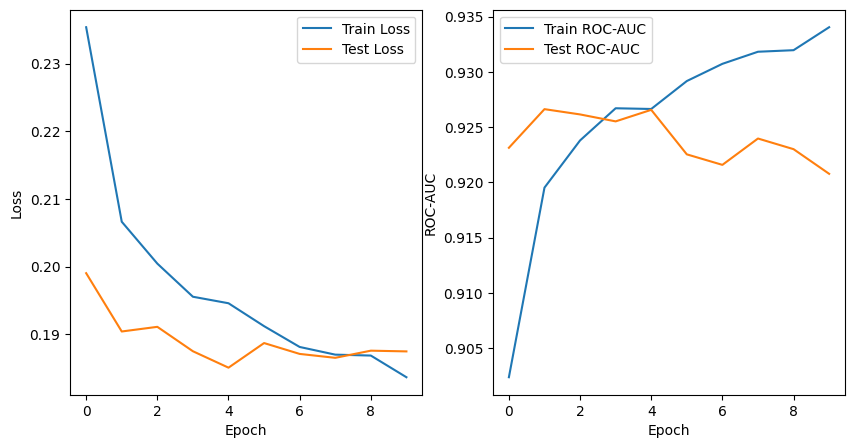

In [40]:
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

В целом модель показывает улучшение на тренировочных данных (Train ROC-AUC), но на тестовых данных результаты стабилизировались. Модель на тесте показывает небольшие колебания в ROC-AUC, но в целом остается высокой.

Модель стабилизировалась в плане улучшения результатов на тестовых данных, но продолжает улучшаться на тренировочных. Это может указывать на небольшое переобучение, так как на тесте не наблюдается значительных улучшений.
Обе метрики (Loss и ROC-AUC) показывают стабильные результаты, что говорит о хорошем качестве модели, но стоит внимательно следить за возможным переобучением, если улучшения на тесте будут слабыми в будущем.

Эксперимент 4. Dropout

Epoch 1/10, Train Loss: 0.3080, Test Loss: 0.2362, Train ROC-AUC: 0.8338, Test ROC-AUC: 0.9147
Epoch 2/10, Train Loss: 0.2704, Test Loss: 0.2200, Train ROC-AUC: 0.8765, Test ROC-AUC: 0.9191
Epoch 3/10, Train Loss: 0.2633, Test Loss: 0.2159, Train ROC-AUC: 0.8837, Test ROC-AUC: 0.9217
Epoch 4/10, Train Loss: 0.2560, Test Loss: 0.2138, Train ROC-AUC: 0.8890, Test ROC-AUC: 0.9235
Epoch 5/10, Train Loss: 0.2526, Test Loss: 0.2111, Train ROC-AUC: 0.8910, Test ROC-AUC: 0.9239
Epoch 6/10, Train Loss: 0.2499, Test Loss: 0.2090, Train ROC-AUC: 0.8937, Test ROC-AUC: 0.9256
Epoch 7/10, Train Loss: 0.2477, Test Loss: 0.2065, Train ROC-AUC: 0.8945, Test ROC-AUC: 0.9259
Epoch 8/10, Train Loss: 0.2441, Test Loss: 0.2046, Train ROC-AUC: 0.8968, Test ROC-AUC: 0.9268
Epoch 9/10, Train Loss: 0.2413, Test Loss: 0.2019, Train ROC-AUC: 0.8996, Test ROC-AUC: 0.9276
Epoch 10/10, Train Loss: 0.2390, Test Loss: 0.2009, Train ROC-AUC: 0.9015, Test ROC-AUC: 0.9280


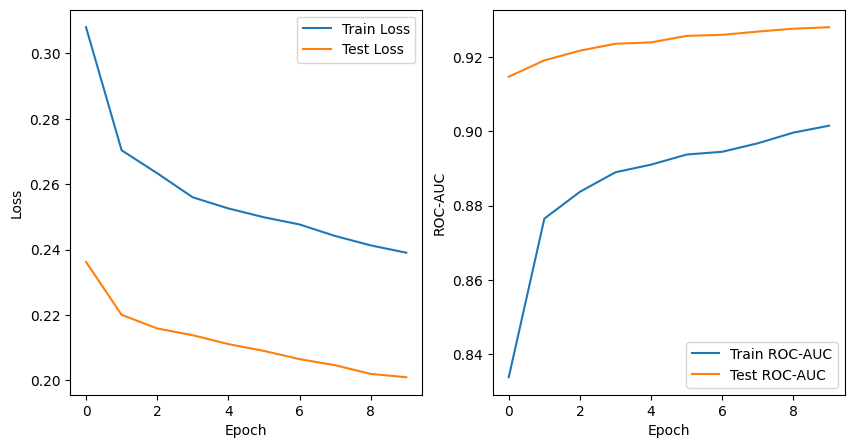

In [43]:
class ModelWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size=128, dropout_prob=0.5):
        super(ModelWithDropout, self).__init__()
        # Линейные слои
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size*4)
        self.fc3 = nn.Linear(hidden_size*4, hidden_size*2)
        self.fc4 = nn.Linear(hidden_size*2, 1)

        # ReLU активация
        self.relu = nn.ReLU()

        # Dropout слои
        self.dropout = nn.Dropout(dropout_prob)

        # BatchNorm
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size*4)
        self.batchnorm3 = nn.BatchNorm1d(hidden_size*2)

        # Дополнительный линейный слой для согласования размерности для Skip Connection
        self.fc_skip = nn.Linear(hidden_size, hidden_size*2)  # Выравнивание размерности

    def forward(self, x):
        # Применяем BatchNorm, Linear, ReLU и Dropout
        x = self.relu(self.batchnorm1(self.fc1(x)))
        x = self.dropout(x)

        skip = x  # Сохраняем "переход" для Skip Connection

        # Применяем BatchNorm, Linear, ReLU и Dropout
        x = self.relu(self.batchnorm2(self.fc2(x)))
        x = self.dropout(x)

        # Применяем слой, чтобы привести размерность skip connection к нужному виду
        skip = self.fc_skip(skip)  # Согласуем размерность для skip connection

        # Применяем BatchNorm и Dropout на выходе
        x = self.relu(self.batchnorm3(self.fc3(x) + skip))  # Skip connection
        x = self.dropout(x)

        # Выходной слой с сигмоидом
        x = torch.sigmoid(self.fc4(x))

        return x.squeeze()

# Пример эксперимента с dropout_prob = 0.5
model = ModelWithDropout(input_size=X_train_processed.shape[1], hidden_size=128, dropout_prob=0.5)
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)


Epoch 1/10, Train Loss: 0.2355, Test Loss: 0.1979, Train ROC-AUC: 0.9023, Test ROC-AUC: 0.9253
Epoch 2/10, Train Loss: 0.2099, Test Loss: 0.1929, Train ROC-AUC: 0.9181, Test ROC-AUC: 0.9240
Epoch 3/10, Train Loss: 0.2020, Test Loss: 0.1878, Train ROC-AUC: 0.9227, Test ROC-AUC: 0.9254
Epoch 4/10, Train Loss: 0.1984, Test Loss: 0.1864, Train ROC-AUC: 0.9243, Test ROC-AUC: 0.9269
Epoch 5/10, Train Loss: 0.1961, Test Loss: 0.1878, Train ROC-AUC: 0.9262, Test ROC-AUC: 0.9239
Epoch 6/10, Train Loss: 0.1927, Test Loss: 0.1873, Train ROC-AUC: 0.9280, Test ROC-AUC: 0.9253
Epoch 7/10, Train Loss: 0.1918, Test Loss: 0.1864, Train ROC-AUC: 0.9278, Test ROC-AUC: 0.9245
Epoch 8/10, Train Loss: 0.1889, Test Loss: 0.1861, Train ROC-AUC: 0.9301, Test ROC-AUC: 0.9247
Epoch 9/10, Train Loss: 0.1890, Test Loss: 0.1842, Train ROC-AUC: 0.9308, Test ROC-AUC: 0.9254
Epoch 10/10, Train Loss: 0.1872, Test Loss: 0.1881, Train ROC-AUC: 0.9314, Test ROC-AUC: 0.9237


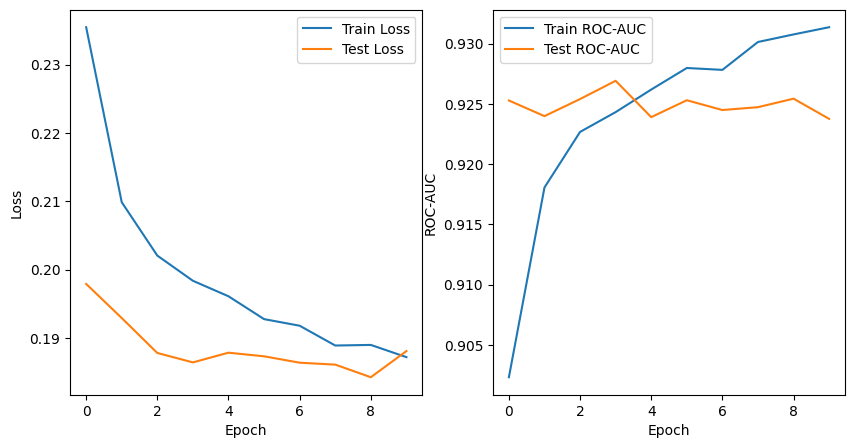

In [44]:
# Пример изменения dropout_prob на 0.01
model = ModelWithDropout(input_size=X_train_processed.shape[1], hidden_size=128, dropout_prob=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)


Epoch 1/10, Train Loss: 0.2524, Test Loss: 0.2015, Train ROC-AUC: 0.8889, Test ROC-AUC: 0.9244
Epoch 2/10, Train Loss: 0.2235, Test Loss: 0.1943, Train ROC-AUC: 0.9104, Test ROC-AUC: 0.9245
Epoch 3/10, Train Loss: 0.2154, Test Loss: 0.1900, Train ROC-AUC: 0.9145, Test ROC-AUC: 0.9283
Epoch 4/10, Train Loss: 0.2126, Test Loss: 0.1907, Train ROC-AUC: 0.9158, Test ROC-AUC: 0.9270
Epoch 5/10, Train Loss: 0.2092, Test Loss: 0.1918, Train ROC-AUC: 0.9173, Test ROC-AUC: 0.9268
Epoch 6/10, Train Loss: 0.2056, Test Loss: 0.1869, Train ROC-AUC: 0.9196, Test ROC-AUC: 0.9283
Epoch 7/10, Train Loss: 0.2049, Test Loss: 0.1885, Train ROC-AUC: 0.9202, Test ROC-AUC: 0.9276
Epoch 8/10, Train Loss: 0.2024, Test Loss: 0.1852, Train ROC-AUC: 0.9217, Test ROC-AUC: 0.9295
Epoch 9/10, Train Loss: 0.2007, Test Loss: 0.1845, Train ROC-AUC: 0.9228, Test ROC-AUC: 0.9290
Epoch 10/10, Train Loss: 0.1992, Test Loss: 0.1848, Train ROC-AUC: 0.9235, Test ROC-AUC: 0.9274


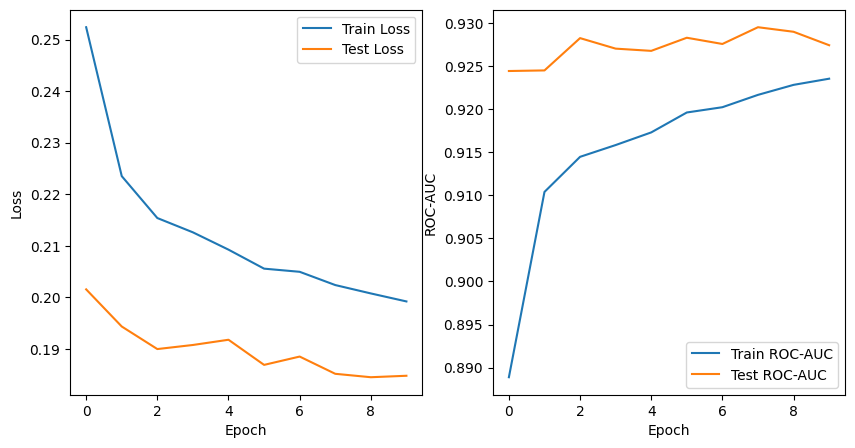

In [45]:
# Пример изменения dropout_prob на 0.1
model = ModelWithDropout(input_size=X_train_processed.shape[1], hidden_size=128, dropout_prob=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Train Loss: 0.2612, Test Loss: 0.2108, Train ROC-AUC: 0.8818, Test ROC-AUC: 0.9206
Epoch 2/10, Train Loss: 0.2342, Test Loss: 0.2000, Train ROC-AUC: 0.9032, Test ROC-AUC: 0.9255
Epoch 3/10, Train Loss: 0.2278, Test Loss: 0.1941, Train ROC-AUC: 0.9073, Test ROC-AUC: 0.9266
Epoch 4/10, Train Loss: 0.2212, Test Loss: 0.1938, Train ROC-AUC: 0.9112, Test ROC-AUC: 0.9265
Epoch 5/10, Train Loss: 0.2181, Test Loss: 0.1931, Train ROC-AUC: 0.9131, Test ROC-AUC: 0.9260
Epoch 6/10, Train Loss: 0.2157, Test Loss: 0.1908, Train ROC-AUC: 0.9136, Test ROC-AUC: 0.9255
Epoch 7/10, Train Loss: 0.2119, Test Loss: 0.1927, Train ROC-AUC: 0.9157, Test ROC-AUC: 0.9247
Epoch 8/10, Train Loss: 0.2114, Test Loss: 0.1984, Train ROC-AUC: 0.9161, Test ROC-AUC: 0.9256
Epoch 9/10, Train Loss: 0.2092, Test Loss: 0.1884, Train ROC-AUC: 0.9174, Test ROC-AUC: 0.9255
Epoch 10/10, Train Loss: 0.2083, Test Loss: 0.1878, Train ROC-AUC: 0.9179, Test ROC-AUC: 0.9267


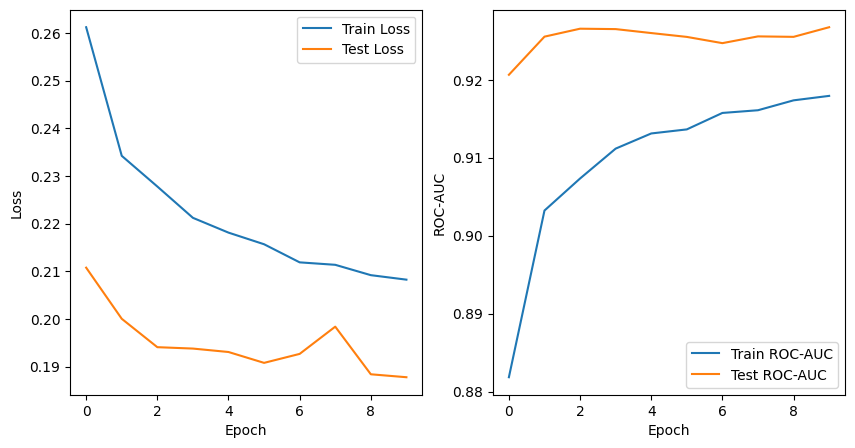

In [46]:
# Пример изменения dropout_prob на 0.2
model = ModelWithDropout(input_size=X_train_processed.shape[1], hidden_size=128, dropout_prob=0.2)
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Train Loss: 0.4420, Test Loss: 0.4220, Train ROC-AUC: 0.5415, Test ROC-AUC: 0.8741
Epoch 2/10, Train Loss: 0.4000, Test Loss: 0.4019, Train ROC-AUC: 0.6395, Test ROC-AUC: 0.8767
Epoch 3/10, Train Loss: 0.3810, Test Loss: 0.3928, Train ROC-AUC: 0.6971, Test ROC-AUC: 0.8852
Epoch 4/10, Train Loss: 0.3653, Test Loss: 0.4075, Train ROC-AUC: 0.7443, Test ROC-AUC: 0.8803
Epoch 5/10, Train Loss: 0.3535, Test Loss: 0.4047, Train ROC-AUC: 0.7750, Test ROC-AUC: 0.8913
Epoch 6/10, Train Loss: 0.3447, Test Loss: 0.4326, Train ROC-AUC: 0.7961, Test ROC-AUC: 0.8939
Epoch 7/10, Train Loss: 0.3385, Test Loss: 0.4102, Train ROC-AUC: 0.8107, Test ROC-AUC: 0.9012
Epoch 8/10, Train Loss: 0.3351, Test Loss: 0.4066, Train ROC-AUC: 0.8167, Test ROC-AUC: 0.9020
Epoch 9/10, Train Loss: 0.3271, Test Loss: 0.3966, Train ROC-AUC: 0.8303, Test ROC-AUC: 0.9053
Epoch 10/10, Train Loss: 0.3233, Test Loss: 0.4171, Train ROC-AUC: 0.8366, Test ROC-AUC: 0.9071


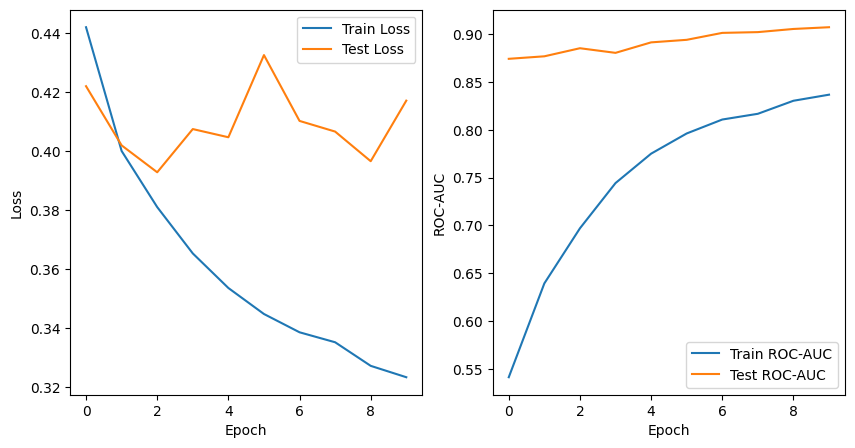

In [48]:
# Пример изменения dropout_prob на 0.9
model = ModelWithDropout(input_size=X_train_processed.shape[1], hidden_size=128, dropout_prob=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

Низкие значения p (например, p = 0.01): Модель склонна к переобучению, что приводит к хорошим результатам на тренировочных данных, но тестовые показатели не улучшаются или даже ухудшаются.

Средние значения p (например, p = 0.1, p = 0.2): Модель обучается стабильно, достигая хороших результатов как на тренировочных, так и на тестовых данных. Эти значения p обеспечивают баланс между обучением и обобщением.

Высокие значения p (например, p = 0.9): Модель начинает с низкой производительности, но постепенно улучшается. Однако результаты на старте показывают, что обучение с таким значением p менее стабильное и требует больше времени для достижения хороших показателей.